In [138]:

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from jones_matrix import JonesMatrix as jm
from jones_matrix import Phases as ph
# change the following to %matplotlib notebook for interactive plotting

In [139]:
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import numba as nb
import pims
import trackpy as tp
import matplotlib.animation as animation

This is a markdown cell. You can change the cell type in the menu `cell->cell type`.
You can read more about [markdown](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html) too.

The cell below defines the director field on a radial droplet the function `f` adds a twist from ref: Liquid Crystals, 1999, Vol. 26, No. 5, 753-758.

$$ f(r) = \frac{1}{\sqrt{r}}\sin\left(\pi\frac{ln(r/r_{min})}{ln(r_{max}/r_{min}}\right) $$


with:

$r$ the radial position in the drop

$r_{max}$ the radius of the drop

$r_{min}$ the radius of the small inclusion contained in the drop

For a point of coordinates (x,y,z), the spherical coordinates are given by

$ r = \sqrt{x^{2}+y^{2}+z^{2}} $

$ \theta = \cos^{-1}\left(\frac{z}{\sqrt{x^{2}+y^{2}+z^{2}}}\right) $

$ \phi = \tan^{-1}\left(\frac{y}{x}\right) $

At this point, the director is defined by the polar coordinates

$n_r = \left(1-0.5\times b^{2}\times f(r)^{2} \right) \times r $

$n_{\phi} = \phi + b \times f(r) $

$n_{\theta} = \theta $

with b being the 'twist amplitude'

We can then obtain back the cartesian coordinates of n:

$n_x = n_r \times sin(n_{\theta}) \times cos(n_{\phi}))$

$n_y = n_r \times sin(n_{\theta}) \times sin(n_{\phi})$

$n_z = n_r \times cos(n_{\theta})$

And thus we obtain the $\beta$ and $\gamma$ angles:

$\beta = cos^{-1}\left(\frac{n_z}{\sqrt{n_x^{2}+n_y^{2}+n_z^{2}}}\right)$

$\gamma = tan^{-1}\left(\frac{n_y}{n_x}\right)$


In [269]:
def f(r,rmin,rmax):
    return 1/np.sqrt(r)*np.sin(np.pi*np.log(r/rmin)/np.log(rmax/rmin))

def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan(y/x)

def nr(x,y,z,b,rmin,rmax):
    return (1-0.5*(b**2)*(f(rd(x,y,z),rmin,rmax)**2))*rd(x,y,z)

def nphi(x,y,z,b,rmin,rmax):
    return b*f(rd(x,y,z),rmin,rmax)+phi(x,y,z)

def ntet(x,y,z):
    return tet(x,y,z)

def nx(x,y,z,b,rmin,rmax):
    return nr(x,y,z,b,rmin,rmax)*np.sin(ntet(x,y,z))*np.cos(nphi(x,y,z,b,rmin,rmax))

def ny(x,y,z,b,rmin,rmax):
    return nr(x,y,z,b,rmin,rmax)*np.sin(ntet(x,y,z))*np.sin(nphi(x,y,z,b,rmin,rmax))

def nz(x,y,z,b,rmin,rmax):
    return nr(x,y,z,b,rmin,rmax)*np.cos(ntet(x,y,z))

def beta(x,y,z,b,rmin,rmax):
    return np.arccos(nz(x,y,z,b,rmin,rmax)/np.sqrt((nx(x,y,z,b,rmin,rmax))**2+(ny(x,y,z,b,rmin,rmax))**2+(nz(x,y,z,b,rmin,rmax))**2))

def gamma(x,y,z,b,rmin,rmax):
    return np.arctan(ny(x,y,z,b,rmin,rmax)/nx(x,y,z,b,rmin,rmax))

In [141]:
def polarizer(ang):
    return np.array([[np.cos(ang)**2,np.cos(ang)*np.sin(ang)],
                     [np.cos(ang)*np.sin(ang),np.sin(ang)**2]],
                    dtype=np.complex)

In [142]:
pol = np.array([[1,0],[0,0]],dtype=np.complex)
ana = np.array([[0,0],[0,1]],dtype=np.complex)

In [143]:
def tw(r,rmax,a):
    return (a/rmax)*(rmax-r)

def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan(y/x)


def nr2(x,y,z):
    return rd(x,y,z)

def nphi2(x,y,z,a,rmax):
    return phi(x,y,z)+tw(rd(x,y,z),rmax,a)

def ntet2(x,y,z):
    return tet(x,y,z)

def nx2(x,y,z,a,rmax):
    return nr2(x,y,z)*np.sin(ntet2(x,y,z))*np.cos(nphi2(x,y,z,a,rmax))

def ny2(x,y,z,a,rmax):
    return nr2(x,y,z)*np.sin(ntet(x,y,z))*np.sin(nphi2(x,y,z,a,rmax))

def nz2(x,y,z):
    return nr2(x,y,z)*np.cos(ntet2(x,y,z))

def beta2(x,y,z,a,rmax):
    return np.arccos(nz2(x,y,z)/np.sqrt((nx2(x,y,z,a,rmax))**2+(ny2(x,y,z,a,rmax))**2+(nz2(x,y,z))**2))

def gamma2(x,y,z,a,rmax):
    return np.arctan(ny2(x,y,z,a,rmax)/nx2(x,y,z,a,rmax))

In [274]:
nphi(10,0,0,1,0.1,10)

3.8726732145403873e-17

In [483]:
rmax = 5
rmin = 0.001
n_ord = 1.55
n_ext = 1.65
lamb = 0.550 #microns
zres = 0.051
xres = 0.051
yres = xres
#wlen = lamb
b = 2
a = 0

In [477]:
x = np.arange(-rmax,rmax,xres)
y = np.arange(-rmax,rmax,yres)
z = np.arange(-rmax,rmax,zres)

In [405]:
res_jm = np.zeros((x.shape[0],y.shape[0],2,2),dtype=np.complex)
res_jm[1,1] = np.identity(2,dtype=np.complex)
mat = jm.jones_matrix(np.pi/4,1.6,1.5)
pol = polarizer(0)
an = polarizer(np.pi/2)
E = np.array([[1],[1]],dtype=np.complex)
print(E)
print(pol)
print(an)
img = np.dot(an,np.dot(mat,pol))
linnorm = np.linalg.norm(img)
print(linnorm)
Exy=np.dot(an,np.dot(mat,np.dot(pol,E)))
Ex=Exy[0]
Exim=np.imag(Ex)
Exrea=np.real(Ex)
Ey=Exy[1]
Eyim=np.imag(Ey)
Eyrea=np.real(Ey)
print(Exim[0])
print(Exrea)
Int=Exrea[0]*Exim[0]+Eyrea[0]*Eyim[0]
print(Int)

[[ 1.+0.j]
 [ 1.+0.j]]
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j]]
[[  3.74939946e-33+0.j   6.12323400e-17+0.j]
 [  6.12323400e-17+0.j   1.00000000e+00+0.j]]
0.0499791692707
6.36392741695e-20
[ -3.05967973e-18]
-5.19325292867e-05


In [339]:
im = np.zeros((x.shape[0],y.shape[0]))
print(Int)
im[1,1] = Int
print(im[1,1])

[ 0.]
0.0


In [251]:
def jm_mat(x,y,z,b,rmin,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    #res_jm = np.ones((x.shape[0],2,2),dtype=np.complex)
    #res_jm[:,0,1] = 0
    #res_jm[:,1,0] = 0
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            res_jm[i,j] = np.identity(2,dtype=np.complex)
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = nphi(xi,yi,zi,b,rmin,rmax)
                    bet = ntet(xi,yi,zi)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen,zres)
                    phior = ph.compute_phiord(n_ord,wlen,zres)
                    #res_jm[i] = np.dot(res_jm[i],
                    #                   jm.jones_matrix(gam,phiex,phior))
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [252]:
def jm_mat2(x,y,z,a,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    #res_jm = np.ones((x.shape[0],2,2),dtype=np.complex)
    #res_jm[:,0,1] = 0
    #res_jm[:,1,0] = 0
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            res_jm[i,j] = np.identity(2,dtype=np.complex)
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = nphi2(xi,yi,zi,a,rmax)
                    bet = ntet2(xi,yi,zi)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen,zres)
                    phior = ph.compute_phiord(n_ord,wlen,zres)
                    #res_jm[i] = np.dot(res_jm[i],
                    #                   jm.jones_matrix(gam,phiex,phior))
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [302]:
def jm_mat3(x,y,z,b,rmin,rmax,wleng):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    #res_jm = np.ones((x.shape[0],2,2),dtype=np.complex)
    #res_jm[:,0,1] = 0
    #res_jm[:,1,0] = 0
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            res_jm[i,j] = np.identity(2,dtype=np.complex)
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    for k,wlengi in enumerate(wleng):
                        gam = nphi(xi,yi,zi,b,rmin,rmax)
                        bet = ntet(xi,yi,zi)
                        phiex = ph.compute_phiex(bet,n_ord,n_ext,wlengi,zres)
                        phior = ph.compute_phiord(n_ord,wlengi,zres)
                        #res_jm[i] = np.dot(res_jm[i],
                        #                   jm.jones_matrix(gam,phiex,phior))
                        res_jm[i,j] = np.dot(wccd[k]*wlamp[k]*jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [485]:
jms = jm_mat(x,y,z,b,rmin,rmax,0.660)

In [232]:
def jmim(jms):
    im = np.zeros((x.shape[0],y.shape[0]))
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            im[i,j] = np.linalg.norm(np.dot(np.dot(polarizer(0),jms[i,j]),
                                      polarizer(np.pi/2)))
    return im

In [369]:
def jmim2(jms):
    im = np.zeros((x.shape[0],y.shape[0]))
    E = np.array([[1],[1]],dtype=np.complex)
    pol = polarizer(0)
    an = polarizer(np.pi/2)
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            Exy = np.dot(np.dot(np.dot(pol,jms[i,j]),an),E)
            Ex = Exy[0]
            Exim = np.absolute(np.imag(Ex))
            Exrea = np.absolute(np.real(Ex))
            Ey = Exy[1]
            Eyim = np.absolute(np.imag(Ey))
            Eyrea = np.absolute(np.real(Ey))
            Int = Exrea[0]*Exim[0]+Eyrea[0]*Eyim[0]
            im[i,j] = Int            
    return im

In [486]:
im = np.zeros((x.shape[0],y.shape[0]))
for i in np.arange(x.shape[0]):
    for j in np.arange(y.shape[0]):
        im[i,j] = np.linalg.norm(np.dot(np.dot(polarizer(0),jms[i,j]),
                                      polarizer(np.pi/2)))

In [487]:
im2 = jmim2(jms)

In [214]:
wlenres = 0.100
wlenmin = 0.400
wlenmax = 0.800
wleng = np.arange(wlenmin,wlenmax+wlenres,wlenres)
wccd = [0.55, 0.6, 0.65, 0.75, 0.9, 1, 1, 1, 0.97, 0.95, 0.92, 0.88, 0.82, 0.78, 0.72, 0.68, 0.62, 0.55, 0.48, 0.44, 0.4]
wlamp = [0.14, 0.2, 0.24, 0.32, 0.37, 0.42, 0.46, 0.51, 0.57, 0.62, 0.66, 0.7, 0.74, 0.78, 0.8, 0.82, 0.84, 0.85, 0.86, 0.87, 0.87]

In [443]:
imt = np.zeros((x.shape[0],y.shape[0]))
for i,wlengi in enumerate(wleng):
    jms = jm_mat(x,y,z,b,rmin,rmax,wlengi)
    im = jmim2(jms)
    imt = imt + im

In [303]:
jms2 = jm_mat3(x,y,z,b,rmin,rmax,wleng)

In [304]:
im3 = jmim(jms2)

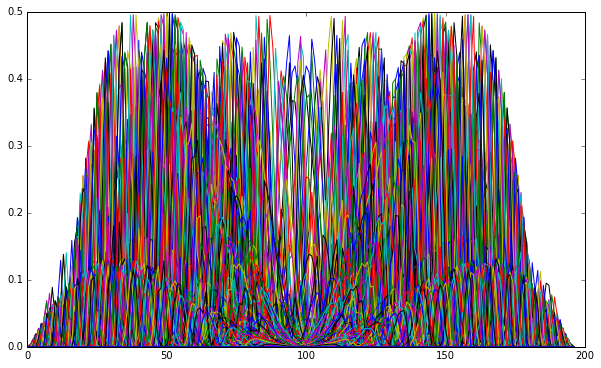

In [488]:
plt.plot(im2)

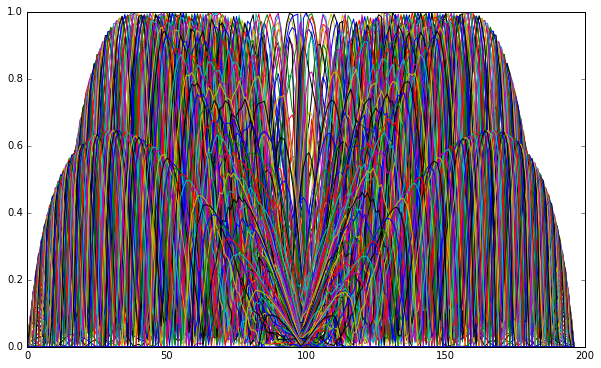

In [489]:
plt.plot(im)

(-6.0, 6.0, -6.0, 6.0)

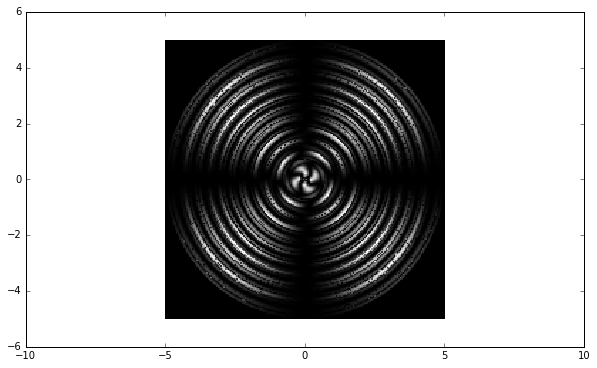

In [490]:
plt.pcolor(x,y,im2,cmap=plt.cm.gray)
plt.axis('equal')

(-6.0, 6.0, -6.0, 6.0)

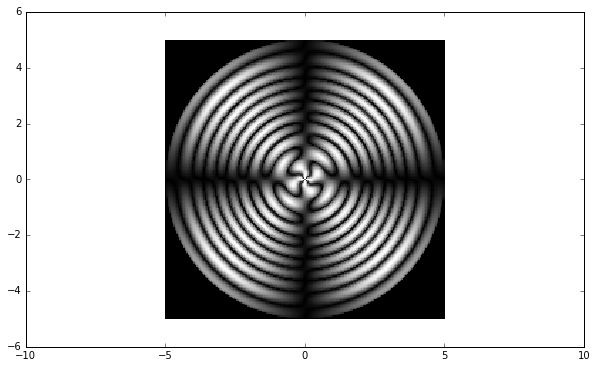

In [491]:
plt.pcolor(x,y,im,cmap=plt.cm.gray)
plt.axis('equal')

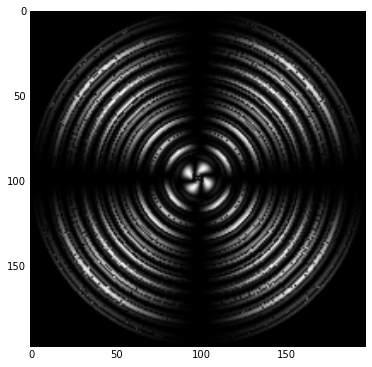

In [482]:
fig=plt.imshow(im2)